## Introduction à Spark

Ce module introductif vise à effleurer l'intêret de l'utilisation de Spark et son utilisation au sein du datalab.
En deux mots je dirai que spark est très utilisé dans les pipelines de traitement de données massive (ETL) et qu'il permet d'écrire du code de la même façon  pour son execution sur une machine unique d'un datascientist ou sur un cluster avec des milliers de cpu. Alors si ca vous tente de voir comment ca tourne.. let's go


#### Contexte spark
Les différentes méthodes d'analyse de données s'appuie sur un **contexte Spark** qui masque la complexité de l'infrastructure sous-jacente au Datascientist. 

Ce contexte spark donne accès à un **driver spark** ( qui tourne dans une JVM scala ) qui lui même a accès à des executor auquels seront distribués les jobs. Ces executor sont obtenues à partir d'un **ressource manager**.
Il y a 5 possibilités :
* local : le cas où le driver crée sur la machine des threads en utilisant la cpu de la machine local
* spark standalone : un ressource manager basique fournit par spark.
* mesos : le ressource manager historique provenant de l'université de Berkeley 
* yarn : le ressource manager présent dans les infras Big data traditionnelles (cluster cloudera/hortonworks par exemple)
* kubernetes : le petit nouveau, l'ogre de l'orchestration de container.

#### Langage de développement
Il existe plusieurs langage pour interargir avec un driver spark :
- scala (natif : la voie royale) 
- python au travers du module pyspark
- r avec sparkr par exemple
- java

Il existe même des outils permettant de dialoguer uniquement en sql vers spark par l'intermédiation du Thrift JDBC/ODBC server.
Bref nous nous focaliserons sur **python** ici.

#### Où êtes vous ?
Vous etes sur une image docker construite ici https://github.com/InseeFrLab/images-datascience/tree/main/spark

Vous avez une installation de spark  et de hadoop deux projets incontournables de l'ecosystème big data.

In [1]:
!hadoop version

Hadoop 3.3.4
Source code repository https://github.com/apache/hadoop.git -r a585a73c3e02ac62350c136643a5e7f6095a3dbb
Compiled by stevel on 2022-07-29T12:32Z
Compiled with protoc 3.7.1
From source with checksum fb9dd8918a7b8a5b430d61af858f6ec
This command was run using /opt/hadoop/share/hadoop/common/hadoop-common-3.3.4.jar


In [2]:
cat /opt/spark/RELEASE

Spark 3.3.0 (git revision f74867b) built for Hadoop 3.3.4
Build flags: -Phadoop-provided -Phadoop-cloud -Phive -Phive-thriftserver -Pkubernetes -Dhadoop.version=3.3.4 -Dhive.version=2.3.9


#### Qu'allons nous faire ?
Dans ce premier module d'une longue série, nous allons simplement :
* créer un **contexte spark local**
* executer les exemples présents sur le site https://spark.apache.org/examples.html

In [3]:
from pyspark.sql import SparkSession

spark = (SparkSession 
         .builder
         .appName("Datalake TP")
         .master("local[5]")
         .getOrCreate()
        )
sc = spark.sparkContext

2022-10-07 15:11:43,040 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
2022-10-07 15:11:43,708 WARN util.Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


Un driver spark expose une IHM web de suivi des jobs, des executors.. Le lien est disponible sur le **README** ici
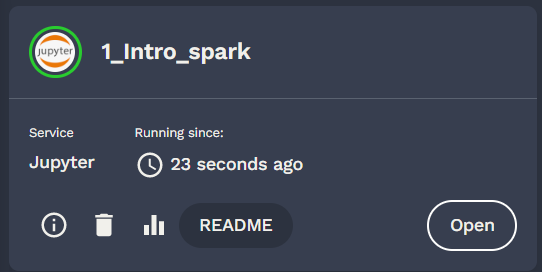

Si tout s'est bien passé dans l'onglet vous devriez voir un driver avec 5 coeurs et aucun executeur. C'est exactement ce qu'on a demandé avec un master local. Ce sont les threads sur le driver qui vont faire le job.

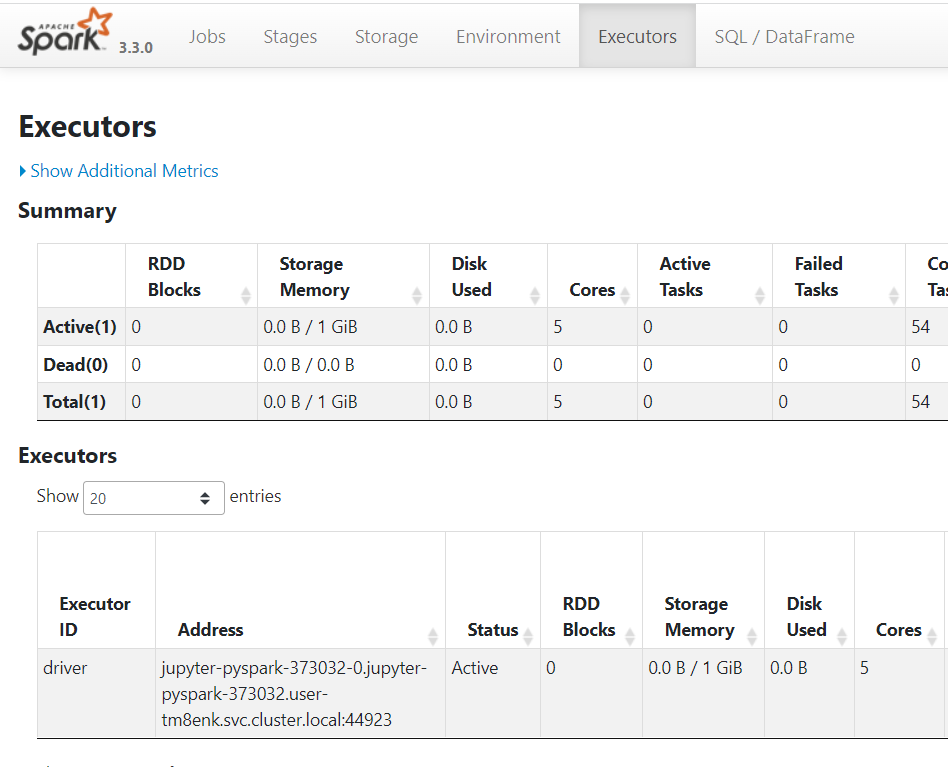

#### Calcul de Pi

Très marrant ce calcul de PI qui consiste à estimer PI en probabilité en tirant des points du carré [0,1]x[0,1] et en regardant ceux qui atterissent dans le quart de cercle de rayon 1 centré sur le point (0,0)

In [4]:
import random

NUM_SAMPLES = 10000000

def inside(p):
    x, y = random.random(), random.random()
    return x*x + y*y < 1

count = sc.parallelize(range(0, NUM_SAMPLES)) \
             .filter(inside).count()
print ("Pi is roughly %f" % (4.0 * count / NUM_SAMPLES))

Pi is roughly 3.141906


La convergence en probabilité est très faible, ce qui illustre si besoin que ce n'est parce qu'on distribue des calculs qu'on fait des choses intelligentes avec :)

**technique :** dans cet exemple nous avons distribué les entiers de 0 à NUM_SAMPLES avec la fonction parrallelize. En pratique chaque executeur à reçu son lot d'entiers de la part du driver. Le driver a en mémoire la liste complète.. cette parallèlisation ne passe pas vraiment à l'échelle.

#### Wordcount

Exemple ultra classique coté Big Data, le comptage de mot.
On va compter les mots de ce module pour voir de quoi il parle


Pour cela nous allons télécharger un fichier de données avec l'outil en ligne de commande mc (existant dans chaque service du datalab).
Evidemment il aurait été possible d'utiliser des apis pythons pour cela.

In [5]:
!mc cp s3/projet-spark-lab/diffusion/formation/data/trump-tweets/trump_insult_tweets_2014_to_2021.csv .

...o_2021.csv: 2.68 MiB / 2.68 MiB ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.09 MiB/s 0s

In [6]:
text_file = sc.textFile("trump_insult_tweets_2014_to_2021.csv")
counts = text_file.flatMap(lambda line: line.split(" ")) \
             .map(lambda word: (word, 1)) \
             .reduceByKey(lambda a, b: a + b) \
             .sortBy(lambda a : - a[1] )

counts.take(20)

[('the', 16501),
 ('and', 9009),
 ('to', 8773),
 ('of', 7064),
 ('a', 6995),
 ('is', 6904),
 ('in', 4944),
 ('for', 3896),
 ('that', 3405),
 ('are', 3319),
 ('on', 3151),
 ('&', 2914),
 ('I', 2741),
 ('be', 2522),
 ('have', 2464),
 ('with', 2323),
 ('was', 2245),
 ('they', 2114),
 ('Fake', 2009),
 ('will', 1941)]

Ce qui nous montre plein de choses :
* qu'il y a pas mal de travail pour analyser un texte et le nettoyer
* que Fake semble être le mot signifiant le plus représenté

**technique :** Ici la source est un fichier local, il faut que chaque executor ait accès à ce fichier localement. Ici c'est facile car tous les threads sont sur ce driver mais quand on va distribuer les calculs sur un cluster il va falloir apprendre à se servir d'un stockage distant. C'est l'objet du prochain tutorial. 

## Pensez à éteindre votre SparkSession lorsque vous avez terminé

In [17]:
spark.stop()